# Midterm-Project: Urban Green Space Accessibility and Suitability Analysis for Graz, Austria

Authors: Kocheganova Adilya, Wutte Timon, Flor Maximilian

Course: GIS analysis techniques 2 (VU, WS25)

Date: 13/12/2025

Moisa et al. (2023): Urban green space suitability analysis using geospatial techniques: a case study of Addis Ababa, Ethiopia. 
Geocarto International. DOI: 10.1080/10106049.2023.2213674.

# Environment Setup


In [43]:
import os
import osmnx as ox
import geopandas as gpd
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import rasterio.merge
from rasterio.mask import mask
import json
from pathlib import Path
import rasterio
from rasterio.transform import from_origin
import rioxarray
from rasterio import Affine
from rasterio.enums import Resampling
from rasterio.warp import calculate_default_transform, reproject
import rasterio
from rasterio.features import rasterize
from rasterio.warp import calculate_default_transform, reproject, Resampling
from IPython.display import display, Image

In [44]:




if 'PROJ_LIB' in os.environ:
    current_path = os.environ['PROJ_LIB']
    if "PostgreSQL" in current_path or "PostGIS" in current_path:
        print(f"⚠️ Konflikt gefunden: PROJ_LIB zeigte auf {current_path}")
        print("✅ Lösche Umgebungsvariable für diese Session...")
        del os.environ['PROJ_LIB']


try:
    import pyproj
    internal_proj_path = pyproj.datadir.get_data_dir()
    os.environ['PROJ_LIB'] = internal_proj_path
    print(f"✅ PROJ_LIB erfolgreich auf Python-internen Pfad gesetzt: {internal_proj_path}")
except ImportError:
    print("ℹ️ Pyproj nicht direkt gefunden, hoffe auf Rasterio-internen Fallback.")


import rasterio
from rasterio.transform import from_origin


✅ PROJ_LIB erfolgreich auf Python-internen Pfad gesetzt: /Volumes/Maximilian/Studium/Geo_Master/Wintersemester_25/3_GIS_AT_2/env_gis_at_2/lib/python3.11/site-packages/pyproj/proj_dir/share/proj


# Graz Boundary Extraction and Visualization


Saved Graz boundary to: data/Graz31256.geojson
CRS: EPSG:31256


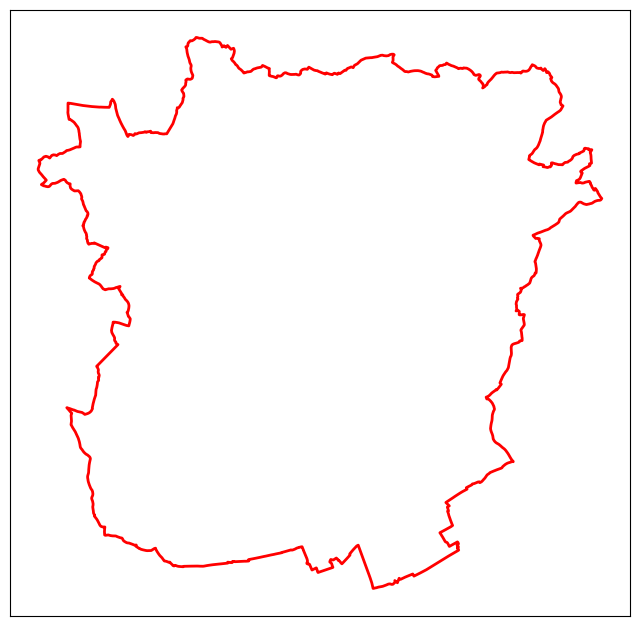

In [45]:
"""
PAPER LINK: https://www.researchgate.net/publication/370700133_Urban_green_space_suitability_analysis_using_geospatial_techniques_a_case_study_of_Addis_Ababa_Ethiopia

"""

PLACE = "Graz, Austria"

graz = ox.geocode_to_gdf(PLACE)
graz_31256 = graz.to_crs(31256)

# Bounds
minx, miny, maxx, maxy = map(float, graz_31256.total_bounds)


out_path = Path("data/Graz31256.geojson")
graz_31256.to_file(out_path, driver="GeoJSON")

print("Saved Graz boundary to:", out_path)
print("CRS:", graz_31256.crs)

# Plot
fig, ax = plt.subplots(figsize=(8, 8))

graz_31256.plot(
    ax=ax,
    facecolor="none",
    edgecolor="red",
    linewidth=2
)

ax.set_xticks([])
ax.set_yticks([])
#ax.set_title("Graz Boundary (EPSG:31256)", fontsize=14)

plt.show()

# DEM Clipping to Graz Boundary
Clip the DEM raster to the Graz boundary and save the result for further analysis.

In [46]:


# Paths
dem_path = Path("data/dem_mosaic31256.tif")
graz_path = Path("data/Graz31256.geojson")

# Load Graz polygon
graz = gpd.read_file(graz_path)


# Extract geometry in GeoJSON format
graz_geom = [json.loads(graz.to_json())["features"][0]["geometry"]]

# Clip raster
with rasterio.open(dem_path) as src:
    dem_clip, dem_transform = mask(
        src,
        graz_geom,
        crop=True,
        nodata=src.nodata
    )
    clip_meta = src.meta.copy()
    clip_meta.update({
        "height": dem_clip.shape[1],
        "width": dem_clip.shape[2],
        "transform": dem_transform,
        "nodata": src.nodata
    })

# Save clipped DEM
clip_path = Path("data/dem_graz31256.tif")

with rasterio.open(clip_path, "w", **clip_meta) as dst:
    dst.write(dem_clip)

print("DEM Graz saved:", clip_path)

# Quick min/max check
import numpy as np
masked = np.ma.masked_equal(dem_clip, clip_meta["nodata"])
print("DEM Graz min:", masked.min(), "max:", masked.max())

DEM Graz saved: data/dem_graz31256.tif
DEM Graz min: 326.22 max: 758.16


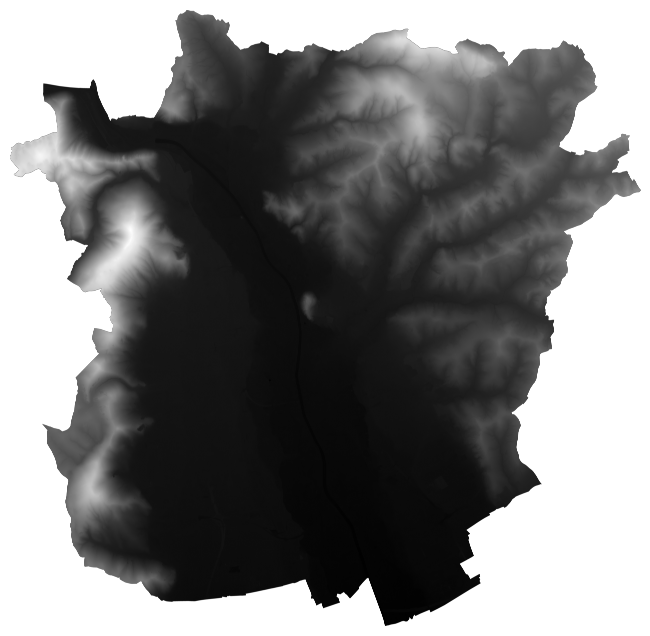

In [47]:

nodata = clip_meta["nodata"]

# Remove band dimension and mask NoData
dem = dem_clip[0]
masked = np.ma.masked_equal(dem, nodata)

plt.figure(figsize=(10, 8))
plt.imshow(masked, cmap="gray")  

#plt.title("DEM Graz")
plt.axis("off")
plt.show()

# Slope Calculation from DEM


In [48]:


dem_path = "data/dem_graz31256.tif"

slope_path = "data/SlopeGraz31256.tif"


with rasterio.open(dem_path) as src:
    dem = src.read(1)
    transform = src.transform
    crs = src.crs
    nodata = src.nodata

    # cell size in x und y (Meter)
    xres = transform.a
    yres = -transform.e

    # compute gradients in x, y direction (Sobel like)

    gy, gx = np.gradient(dem, yres, xres)  # yres, xres als Abstand

    # slope in radians → in degree
    slope = np.degrees(np.arctan(np.sqrt(gx*gx + gy*gy)))

    # set NoData mask
    slope = np.where(dem == nodata, nodata, slope)


    meta = src.meta.copy()
    meta.update({
        "dtype": "float32",
        "nodata": nodata,
        "compress": "lzw"
    })

    # Write to new GeoTIFF
    with rasterio.open(slope_path, "w", **meta) as dst:
        dst.write(slope.astype('float32'), 1)

print("Slope raster safed:", slope_path)

Slope raster safed: data/SlopeGraz31256.tif


# Urban Atlas Clipping and Preparation


In [49]:

# Paths
ua_path   = Path("data/UrbanAtlas31256.gpkg")
graz_path = Path("data/Graz31256.geojson")

# Load layers
urban_atlas = gpd.read_file(ua_path)
graz = gpd.read_file(graz_path)



# Fix: explicitly set correct CRS for Urban Atlas
urban_atlas = urban_atlas.set_crs("EPSG:31256", allow_override=True)

print("Urban Atlas CRS:", urban_atlas.crs)

# Clip Urban Atlas to Graz boundary
ua_graz = gpd.clip(urban_atlas, graz)

print("Original UA features:", len(urban_atlas))
print("Clipped UA features:", len(ua_graz))

# Save clipped Urban Atlas
ua_clip_path = Path("data/UrbanAtlasGraz31256.gpkg")
ua_graz.to_file(ua_clip_path, driver="GPKG")

print("Clipped Urban Atlas saved to:", ua_clip_path)


Urban Atlas CRS: EPSG:31256
Original UA features: 53713
Clipped UA features: 4344
Clipped Urban Atlas saved to: data/UrbanAtlasGraz31256.gpkg


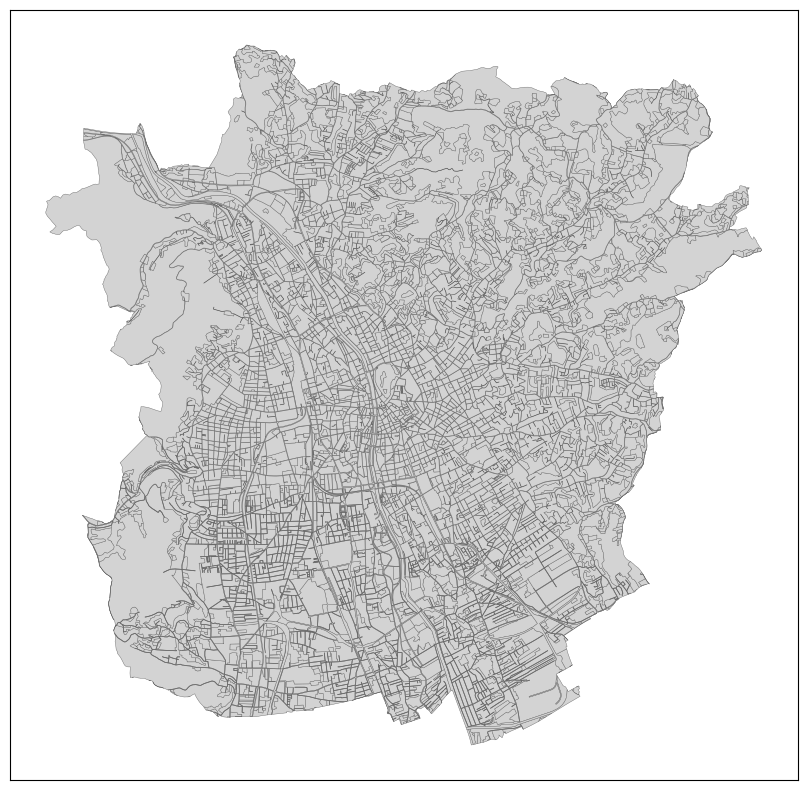

In [50]:


# Load clipped Urban Atlas (EPSG:31256)
ua_path = "data/UrbanAtlasGraz31256.gpkg"
ua_graz = gpd.read_file(ua_path)

# Plot
fig, ax = plt.subplots(figsize=(10, 8))

ua_graz.plot(
    ax=ax,
    color="lightgray",    # uniform gray fill
    edgecolor="dimgray",  
    linewidth=0.3
)

#ax.set_title("UrbanAtlasGraz", fontsize=14)
ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
plt.show()


# Urban Atlas Rasterization


In [51]:


# Original Urban Atlas (ohne Veränderungen)
ua_path = Path("data/UrbanAtlasGraz31256.gpkg")

# Neuer Output mit Integer-Spalte
ua_out_path = Path("data/UrbanAtlasGraz31256_code2018.gpkg")

# Load original layer
ua = gpd.read_file(ua_path)

print("Original dtype:", ua["code_2018"].dtype)

# Create new integer field
ua["code18_int"] = ua["code_2018"].astype(int)

print("Converted dtype:", ua["code18_int"].dtype)

# Save as NEW file
ua.to_file(ua_out_path, driver="GPKG")
print("Saved NEW UrbanAtlas file with integer column →", ua_out_path)

Original dtype: object
Converted dtype: int64
Saved NEW UrbanAtlas file with integer column → data/UrbanAtlasGraz31256_code2018.gpkg


Values for Rasterpixel

In [52]:
import geopandas as gpd
from pathlib import Path

ua_path = Path("data/UrbanAtlasGraz31256_code2018.gpkg")
ua = gpd.read_file(ua_path)

print(ua[["code_2018"]].head())        # sollten z.B. '11100', '13300', ... sein

  code_2018
0     23000
1     50000
2     31000
3     12230
4     12100


In [53]:


# Paths
ua_path   = Path("data/UrbanAtlasGraz31256_code2018.gpkg")
graz_path = Path("data/Graz31256.geojson")
out_path  = Path("data/AUGraz31256Raster_1m.tif")

# Load data
ua   = gpd.read_file(ua_path)
graz = gpd.read_file(graz_path)

# Ensure common CRS (EPSG:31256)
ua   = ua.to_crs(31256)
graz = graz.to_crs(31256)

# Raster extent = Graz boundary
minx, miny, maxx, maxy = graz.total_bounds
pixel_size = 1  # 1 m

width  = int((maxx - minx) / pixel_size)
height = int((maxy - miny) / pixel_size)
transform = from_origin(minx, maxy, pixel_size, pixel_size)

# Prepare shapes: (geometry, class value from code_2018)
shapes = []
for _, row in ua.iterrows():
    if row.geometry is None or row.geometry.is_empty:
        continue
    value = int(row["code_2018"])   # direkt aus der Originalspalte
    shapes.append((row.geometry, value))

# Rasterize
raster = rasterize(
    shapes=shapes,
    out_shape=(height, width),
    transform=transform,
    fill=0,        # outside UA = 0
    dtype="int32"
)

# Save raster
meta = {
    "driver": "GTiff",
    "height": height,
    "width": width,
    "count": 1,
    "dtype": "int32",
    "crs": "EPSG:31256",
    "transform": transform
}

with rasterio.open(out_path, "w", **meta) as dst:
    dst.write(raster, 1)

print("Urban Atlas raster saved →", out_path)

print("unique values:", sorted(list(np.unique(raster))[:10]))

Urban Atlas raster saved → data/AUGraz31256Raster_1m.tif
unique values: [np.int32(0), np.int32(11100), np.int32(11210), np.int32(11220), np.int32(11230), np.int32(11240), np.int32(11300), np.int32(12100), np.int32(12210), np.int32(12220)]


# Population Density Layer Reprojection and Clipping


In [54]:
# Paths
pop_path  = Path("data/aut_ppp_2020_constrained.tif")   # Population density raster
graz_path = Path("data/Graz31256.geojson")      # Graz boundary (EPSG:31256)

# Load Graz boundary
graz_31256 = gpd.read_file(graz_path)

print("Graz CRS:", graz_31256.crs)

# Open population density raster
with rasterio.open(pop_path) as src:
    print("Pop raster CRS:", src.crs)

Graz CRS: EPSG:31256
Pop raster CRS: EPSG:4326


In [55]:


# Paths
src_path = Path("data/aut_ppp_2020_constrained.tif")
dst_path = Path("data/AutPop2020_31256.tif")

# Target CRS
dst_crs = "EPSG:31256"

with rasterio.open(src_path) as src:
    print("Source CRS:", src.crs)

    # Compute target transform, width and height
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds
    )

    # Copy and update metadata
    dst_meta = src.meta.copy()
    dst_meta.update({
        "crs": dst_crs,
        "transform": transform,
        "width": width,
        "height": height
    })

    # Write reprojected raster
    with rasterio.open(dst_path, "w", **dst_meta) as dst:
        for band_idx in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, band_idx),
                destination=rasterio.band(dst, band_idx),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                # Population density = continuous variable → bilinear resampling
                resampling=Resampling.bilinear
            )

print("Reprojected population raster saved to:", dst_path)

Source CRS: EPSG:4326
Reprojected population raster saved to: data/AutPop2020_31256.tif


# Population Density Raster Cleaning


In [56]:


# Paths
pop_path  = Path("data/AutPop2020_31256.tif")
graz_path = Path("data/Graz31256.geojson")
clip_path = Path("data/AutPop2020_Graz31256temp.tif")

# Load Graz boundary
graz = gpd.read_file(graz_path)

with rasterio.open(pop_path) as src:
    # Reproject boundary to raster CRS if needed
    graz_raster = graz.to_crs(src.crs)

    # Extract geometry
    geom = [json.loads(graz_raster.to_json())["features"][0]["geometry"]]

    # Clip (NoData kept as src.nodata)
    clipped, transform = mask(
        src,
        geom,
        crop=True,
        nodata=src.nodata
    )

    meta = src.meta.copy()
    meta.update({
        "height": clipped.shape[1],
        "width": clipped.shape[2],
        "transform": transform,
        "nodata": src.nodata
    })

# Save temporary clipped raster
with rasterio.open(clip_path, "w", **meta) as dst:
    dst.write(clipped)

print("Clipped raster saved:", clip_path)

Clipped raster saved: data/AutPop2020_Graz31256temp.tif


In [57]:


src_path = Path("data/AutPop2020_Graz31256temp.tif")
dst_path = Path("data/PopDensGraz31256_final.tif")

with rasterio.open(src_path) as src:
    arr = src.read(1)

    nodata = src.nodata
    print("nodata:", nodata)

    # Replace nodata with 0
    arr = np.where(arr == nodata, 0, arr)
    arr = np.where(np.isnan(arr), 0, arr)

    # Update metadata: remove nodata flag
    meta = src.meta.copy()
    meta.pop("nodata", None)

    with rasterio.open(dst_path, "w", **meta) as dst:
        dst.write(arr, 1)

print("Filled raster saved:", dst_path)

# Check values
print("min:", arr.min(), "max:", arr.max())

nodata: -99999.0
Filled raster saved: data/PopDensGraz31256_final.tif
min: 0.0 max: 36.58268


In [58]:
with rasterio.open("data/PopDensGraz31256_final.tif") as src:
    arr = src.read(1)
    print(arr.max())

36.58268


# Classification and Weighting Preparation
Prepare for the classification and weighting of input layers for suitability analysis.

In [59]:
# define the place name
place_name:str = "Graz, Austria"
# get the boundary polygon of Graz
graz_gdf = ox.geocode_to_gdf(place_name)
graz_gdf.to_file("data/graz_boundary.geojson", driver="GeoJSON")
# change the crs to an Austrian metric CRS EPSG: 31256
graz_gdf = graz_gdf.to_crs(epsg=31256)






# Road and Drainage Network Extraction
Extract road and drainage networks from OpenStreetMap and save as GeoJSON for further processing.

In [60]:
"""
The author's of the paper obtained the road and drainage network from the Ministry of Agriculture
and the Addis Ababa city land administration. We use the logical equivalent from OSM.
Paper speaks of "drainage" also in respect to recreation. For that, we will choose rivers and streams.
tags: waterway=river, waterway=stream, waterway=canal for drainage network

For the road network, accessibility relevant, so will choose the drivable road network.
network_type='drive' for drivable road network (excluding footways, cycleways, etc.)
"""

# get the road network within Graz
road_graph = ox.graph_from_place(place_name, network_type='drive')
road_gdf = ox.graph_to_gdfs(road_graph, nodes=False, edges=True)
road_gdf = road_gdf.to_crs(epsg=31256)
road_gdf.to_file("data/graz_road_network.geojson", driver="GeoJSON")

# get the drainage network within Graz
#https://wiki.openstreetmap.org/wiki/Key:waterway
drainage_tags = {'waterway': ['river', 'stream', 'canal']}
drainage_gdf = ox.features_from_place(place_name, tags=drainage_tags)
drainage_gdf = drainage_gdf.to_crs(epsg=31256)
drainage_gdf.to_file("data/graz_drainage_network.geojson", driver="GeoJSON")

# we only want lines, no polygons or points
drainage_gdf = drainage_gdf[drainage_gdf.geometry.type.isin(['LineString', 'MultiLineString'])]
drainage_gdf = drainage_gdf[['geometry', 'waterway', 'name']] # keep names
drainage_gdf.to_file("data/graz_drainage_network.geojson", driver="GeoJSON")

# print summary
print(f"Graz boundary: {graz_gdf.shape[0]} features")
print(f"Graz road network: {road_gdf.shape[0]} features")
print(f"Graz drainage network: {drainage_gdf.shape[0]} features")

Graz boundary: 1 features
Graz road network: 11249 features
Graz drainage network: 999 features


In [61]:
from scipy.ndimage import distance_transform_edt

from pathlib import Path
import rasterio



data_dir = Path("data")
master_path = data_dir / "graz_master_grid_10m.tif"
roads_geojson = data_dir / "graz_road_network.geojson"
rivers_geojson = data_dir / "graz_drainage_network.geojson"

output_roads_dist = data_dir / "dist_roads_10m.tif"
output_rivers_dist = data_dir / "dist_rivers_10m.tif"

master_path = data_dir / "graz_master_grid_10m.tif"
with rasterio.open(master_path) as src:
    master_meta = src.meta.copy()
    res = (src.res[0], src.res[1])  # pixel size (x, y)

#vector to raster function
def vector_to_binary_raster(vector_path, meta):
    """
    transforms lines to raster binary image (1 where line is, 0 elsewhere)
    creates "mask"
    returns numpy.ndarray
    """

    gdf = gpd.read_file(vector_path)

    # reproject if needed
    target_crs = meta['crs']
    if gdf.crs != target_crs:
        gdf = gdf.to_crs(target_crs)

    #rasterize function needs a list of pairs: (Geometry, Value)
    #"For every valid geometry, assign the value 1"
    #
    shapes = ((geom, 1) for geom in gdf.geometry if geom is not None and not geom.is_empty)

    binary_image = rasterize( #Turn vectors into pixels (Rasterization)
        shapes=shapes,
        out_shape=(meta['height'], meta['width']), # size of master raster
        transform=meta['transform'],               # positiion master raster
        fill=0,                                    # backgroundn is 0
        default_value=1,                           # lines=1
        dtype='uint8'
    )
    return binary_image


roads_rasterized = vector_to_binary_raster(roads_geojson, master_meta)
rivers_rasterized = vector_to_binary_raster(rivers_geojson, master_meta)
     

#invert binary raster for distance transform
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.distance_transform_edt.html
roads_distance = distance_transform_edt(roads_rasterized == 0, sampling=res)
with rasterio.open(output_roads_dist, "w", **master_meta) as dst:
        dst.write(roads_distance.astype('float32'), 1)
rivers_distance = distance_transform_edt(rivers_rasterized == 0, sampling=res)
with rasterio.open(output_rivers_dist, "w", **master_meta) as dst:
        dst.write(rivers_distance.astype('float32'), 1)


Skipping field highway: unsupported OGR type: 5
Skipping field lanes: unsupported OGR type: 5
Skipping field maxspeed: unsupported OGR type: 5
Skipping field name: unsupported OGR type: 5
Skipping field width: unsupported OGR type: 5
Skipping field access: unsupported OGR type: 5
Skipping field tunnel: unsupported OGR type: 5


# Align all input rasters to a common master grid to ensure spatial consistency

In [62]:
"""
Reclassficiation of dataset according to paper
"""

in_slope = data_dir / "aligned_slope_10m.tif"
in_pop = data_dir / "aligned_pop_10m.tif"
in_ua = data_dir / "aligned_ua_10m.tif"
in_road_dist = data_dir / "dist_roads_10m.tif"
in_river_dist = data_dir / "dist_rivers_10m.tif"
in_ndvi = data_dir / "aligned_ndvi_10m.tif"

out_slope_score = data_dir / "score_slope.tif"
out_pop_score = data_dir / "score_pop.tif"
out_ua_score = data_dir / "score_ua.tif"
out_road_score = data_dir / "score_roads.tif"
out_river_score = data_dir / "score_rivers.tif"
out_ndvi_score = data_dir / "score_ndvi.tif"

def reclassify_raster(input_path, output_path, conditions, scores, default_score=1):
    """
    Converts continuous values into discrete scores (1–5).

    conditions: List of conditions True/False rules (e.g., [data < 5, data < 10])
    scores: The score to award if the rule is True (e.g., [5, 4])
    default_score: The fallback score if a pixel fits NO rules
    """
    with rasterio.open(input_path) as src:
        data = src.read(1) #first "band"
        meta = src.meta.copy() #copy metadata settings
        nodata = src.nodata #get nodata value

    # NOT "empty" marker AND NOT a "NaN"
    valid_mask = (data != nodata) & (~np.isnan(data))
    
    # creation of blank canvas, new array exactly shape as "data"
    # Fill whole array with default score first
    classified = np.full_like(data, default_score, dtype='uint8')
    
    # decision maker, massive if/Else chain
    # looks at the first condition. If True -> Assign first Score.
    # If False, look at second condition. If True -> Assign second Score.
    # If all False -> Assign default.
    classified[valid_mask] = np.select( #only take valid ones
        [cond[valid_mask] for cond in conditions], 
        scores, 
        default=default_score
    )
    
    # set NoData back to 0
    classified[~valid_mask] = 0
    
    meta.update(dtype='uint8', nodata=0)
    
    with rasterio.open(output_path, "w", **meta) as dst:
        dst.write(classified, 1)
        
    print(f"reclassified {output_path.name}")

# SLOPE

with rasterio.open(in_slope) as src:
    slope_data = src.read(1)


slope_conds = [
    slope_data < 5,
    (slope_data >= 5) & (slope_data < 10),
    (slope_data >= 10) & (slope_data < 15),
    (slope_data >= 15) & (slope_data < 30)
]
slope_scores = [5, 4, 3, 2]

reclassify_raster(in_slope, out_slope_score, slope_conds, slope_scores, default_score=1)



# ROADS
# Paper argues that 500m means "accessible by foot", but for Graz this is all of the city basically
# we narrow down the conditions a bit 
# old scoring: 500-1000-1500-2000
with rasterio.open(in_road_dist) as src:
    r_data = src.read(1)

dist_conds = [
    r_data < 50,
    (r_data >= 50) & (r_data < 100),
    (r_data >= 100) & (r_data < 200),
    (r_data >= 200) & (r_data < 2000)
]
dist_scores = [5, 4, 3, 2] # > 2000 wird 1

reclassify_raster(in_road_dist, out_road_score, dist_conds, dist_scores, default_score=1)

# RIVERS
# same as roads, we change it up a bit for Graz
# old scoring: 100-1000-1500-2000
with rasterio.open(in_river_dist) as src:
    riv_data = src.read(1)

#New conditions based on vibes for Graz
riv_conds = [
    riv_data < 50,
    (riv_data >= 50) & (riv_data < 100),
    (riv_data >= 100) & (riv_data < 200),
    (riv_data >= 200) & (riv_data < 2000)
]

reclassify_raster(in_river_dist, out_river_score, riv_conds, dist_scores, default_score=1)

# POPULATION

with rasterio.open(in_pop) as src:
    pop_data = src.read(1)

# paper uses pop/ha and 10x the factor we use here, is this correct?
# need to check paper again and data units
pop_conds = [
    pop_data > 30,       # Score 5
    (pop_data > 20) & (pop_data <= 30), # Score 4
    (pop_data > 10) & (pop_data <= 20), # Score 3
    (pop_data > 5) & (pop_data <= 10) # Score 2
]
pop_scores = [5, 4, 3, 2] # < 0.5 wird 1

reclassify_raster(in_pop, out_pop_score, pop_conds, pop_scores, default_score=1)


# URBAN ATLAS LULC
"""
The LULC of the Addis Ababa city were produced from Landsat images of the
study area and classified into five classes. These classes are agriculture, bare land, built up
area, grassland and vegetation (Table 5; Figure 5). According to Abebe and Megento
(2017) and Girma et al. (2019) suggested that vegetation, bare land and grassland are the
best area for UGS development.
"""
with rasterio.open(in_ua) as src:
    ua_data = src.read(1)

# Urban Atlas Codes groups
# https://land.copernicus.eu/en/technical-library/urban-atlas-2018-validation-report/@@download/file
# Score 5: agriculture, open grasslands
cond_5 = (ua_data >= 20000) & (ua_data < 30000) 

# Score 4: Forests & green urban areas
cond_4 = ((ua_data >= 30000) & (ua_data < 40000)) | (ua_data == 14100)

# Score 3: Low-medium density residential, sports & leisure
cond_3 = (ua_data == 11210) | (ua_data == 11220) 

# Score 1: high density, streets, indutrial, commercial, railways, airports, etc. (default)

ua_conds = [cond_5, cond_4, cond_3]
ua_scores = [5, 4, 3]

reclassify_raster(in_ua, out_ua_score, ua_conds, ua_scores, default_score=1)

# NDVI

with rasterio.open(in_ndvi) as src:
    ndvi_data = src.read(1)

ndvi_conds = [
    ndvi_data > 0.3,                        # Score 5
    (ndvi_data > 0.2) & (ndvi_data <= 0.3), # Score 4
    (ndvi_data > 0.1) & (ndvi_data <= 0.2), # Score 3
    (ndvi_data > 0) & (ndvi_data <= 0.1)    # Score 2
]

ndvi_scores_list = [5, 4, 3, 2] 

reclassify_raster(in_ndvi, out_ndvi_score, ndvi_conds, ndvi_scores_list, default_score=1)




reclassified score_slope.tif
reclassified score_roads.tif
reclassified score_rivers.tif
reclassified score_pop.tif
reclassified score_ua.tif
reclassified score_ndvi.tif


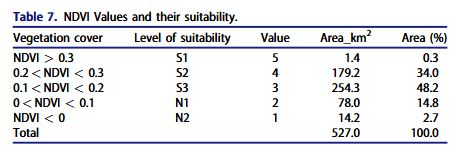

In [63]:
display(Image(filename="data/ndvi_table.JPG"))

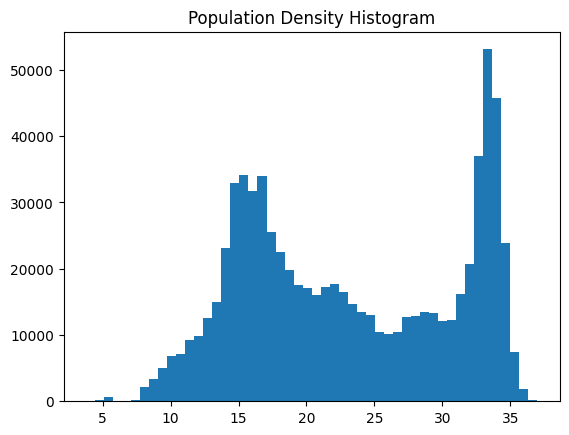

In [64]:
with rasterio.open(in_pop) as src:
    data = src.read(1).flatten()

    data = data[data > 0]
    
    plt.hist(data, bins=50)
    plt.title("Population Density Histogram")
    plt.show()

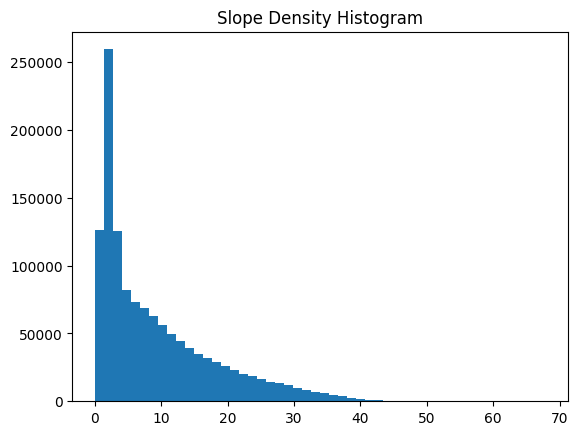

In [65]:
with rasterio.open(in_slope) as src:
    data = src.read(1).flatten()
    data = data[data > 0]
    plt.hist(data, bins=50)
    plt.title("Slope Density Histogram")
    plt.show()


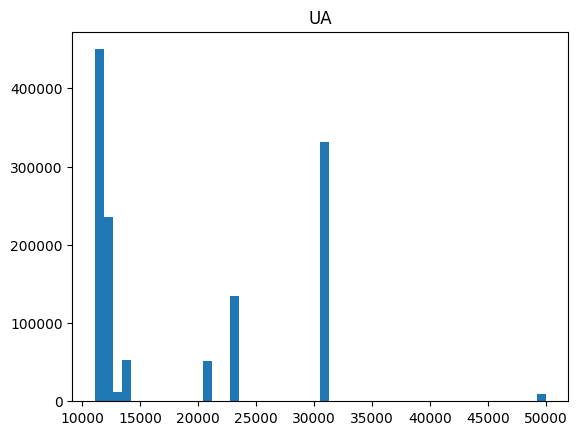

In [66]:
with rasterio.open(in_ua) as src:
    data = src.read(1).flatten()
    data = data[data > 0]
    plt.hist(data, bins=50)
    plt.title("UA")
    plt.show()

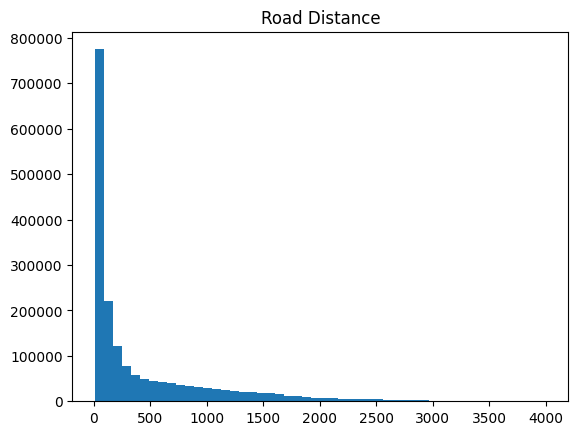

In [67]:
with rasterio.open(in_road_dist) as src:
    data = src.read(1).flatten()
    data = data[data > 0]
    plt.hist(data, bins=50)
    plt.title("Road Distance")
    plt.show()

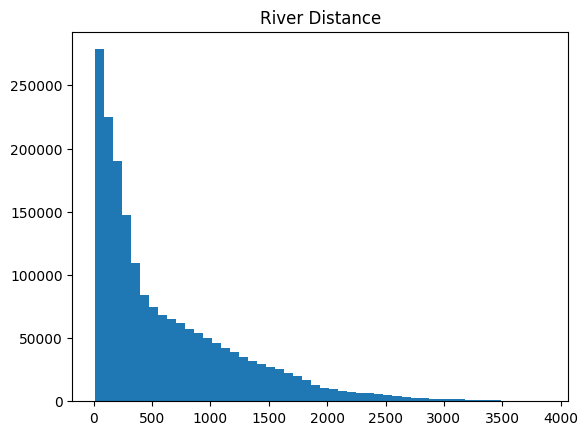

In [68]:
with rasterio.open(in_river_dist) as src:
    data = src.read(1).flatten()
    data = data[data > 0]
    plt.hist(data, bins=50)
    plt.title("River Distance")
    plt.show()

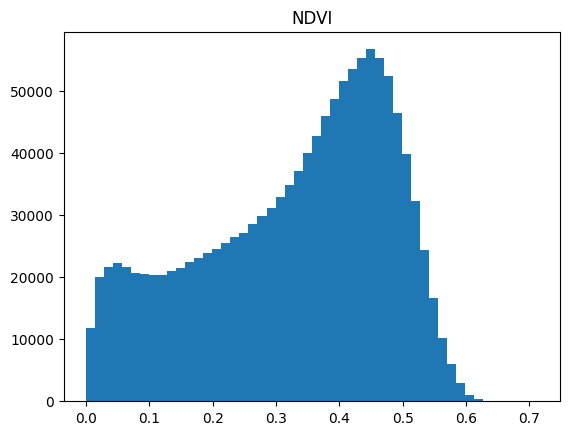

In [69]:
with rasterio.open(in_ndvi) as src:
    data = src.read(1).flatten()
    data = data[data > 0]
    plt.hist(data, bins=50)
    plt.title("NDVI")
    plt.show()

In [70]:
"""
Combine all suitability scores into final suitability map
"""
from rasterio.mask import mask

graz_shape_path = data_dir / "Graz31256.geojson"
graz_gdf = gpd.read_file(graz_shape_path)
graz_geometry = graz_gdf.geometry.values
out_final = data_dir / "final_suitability_map.tif"

files = [
    out_slope_score,
    out_pop_score,
    out_ua_score,
    out_road_score,
    out_river_score,
    out_ndvi_score
]


# Based on table 3 in the paper, changed for 6 parameters
# Weights need to sum to 1.0
# this we could do more mathematically correctly, but for now we just adapt the weights manually
weight_list = [
    0.10,  # Slope (gehört zu out_slope_score)
    0.30,  # Pop   (gehört zu out_pop_score)
    0.15,  # UA    (gehört zu out_ua_score)
    0.15,  # Roads (gehört zu out_road_score)
    0.10,  # Rivers(gehört zu out_river_score)
    0.20   # NDVI  (gehört zu out_ndvi_score)
]


def calculate_final_map():
    """
    Weighted linear combination and clips to city boundary
    final pixel = (score1*weight1) + (score2*weight2) + ...
    """
    with rasterio.open(files[0]) as src:
        meta = src.meta.copy()
        shape = src.shape
        #create empty array of Zeros with same shape as first input raster
        final_array = np.zeros(src.shape, dtype=np.float32) #Float!!!
        transform = src.transform

    for filepath, weight in zip(files, weight_list):
        with rasterio.open(filepath) as src:
            data = src.read(1) # first and only layer (tiffs with one band)
            data = np.where(data == src.nodata, 0, data) #ignore NaNs (-9999 would mess up calculation)
            final_array += (data * weight) #add pixel value * weight to total sum

    #array is still a rectangle
    # we need to mask out everything outside Graz boundary
    # Is pixel inside Graz?
    mask = rasterio.features.geometry_mask(
        graz_gdf.geometry,
        out_shape=shape,
        transform=transform,
        invert=True
    )
    
    #outside Graz = NoData
    final_array[~mask] = -9999

    meta.update(dtype="float32", nodata=-9999)

    with rasterio.open(out_final, "w", **meta) as dst:
        dst.write(final_array, 1)

    print(f"Saved {out_final}")

final_map = calculate_final_map()

Saved data/final_suitability_map.tif


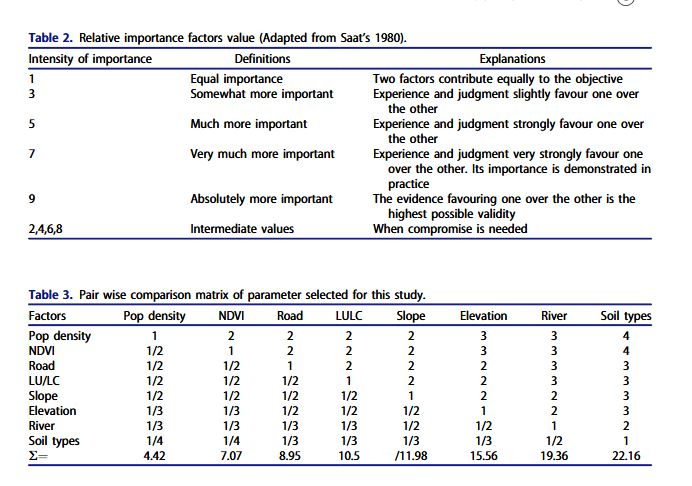

In [71]:
display(Image(filename="data/comparison_matrix.JPG"))

In [72]:
#classify map into 5 suitability classes
out_classified = data_dir / "final_classified_graz.tif"

def classify(raw_array, meta):
    classes = np.zeros_like(raw_array, dtype='uint8')
    valid = raw_array != meta['nodata']
    data = raw_array[valid]

    # for future: no manual classes but quantiles or similar
    conds = [
        data >= 4.2,                # Very High
        (data >= 3.4) & (data < 4.2), # High
        (data >= 2.6) & (data < 3.4), # Moderate
        (data >= 1.8) & (data < 2.6), # Low
        data < 1.8                  # Very Low
    ]
    choices = [5, 4, 3, 2, 1]
    
    #what does this do exactly?
    classes[valid] = np.select(conds, choices, default=1)

    meta.update(dtype='uint8', nodata=0)
    with rasterio.open(out_classified, "w", **meta) as dst:
        dst.write(classes, 1)
        
with rasterio.open(out_final) as src:
    classify(src.read(1), src.meta)

# Plot 6 Input Layer

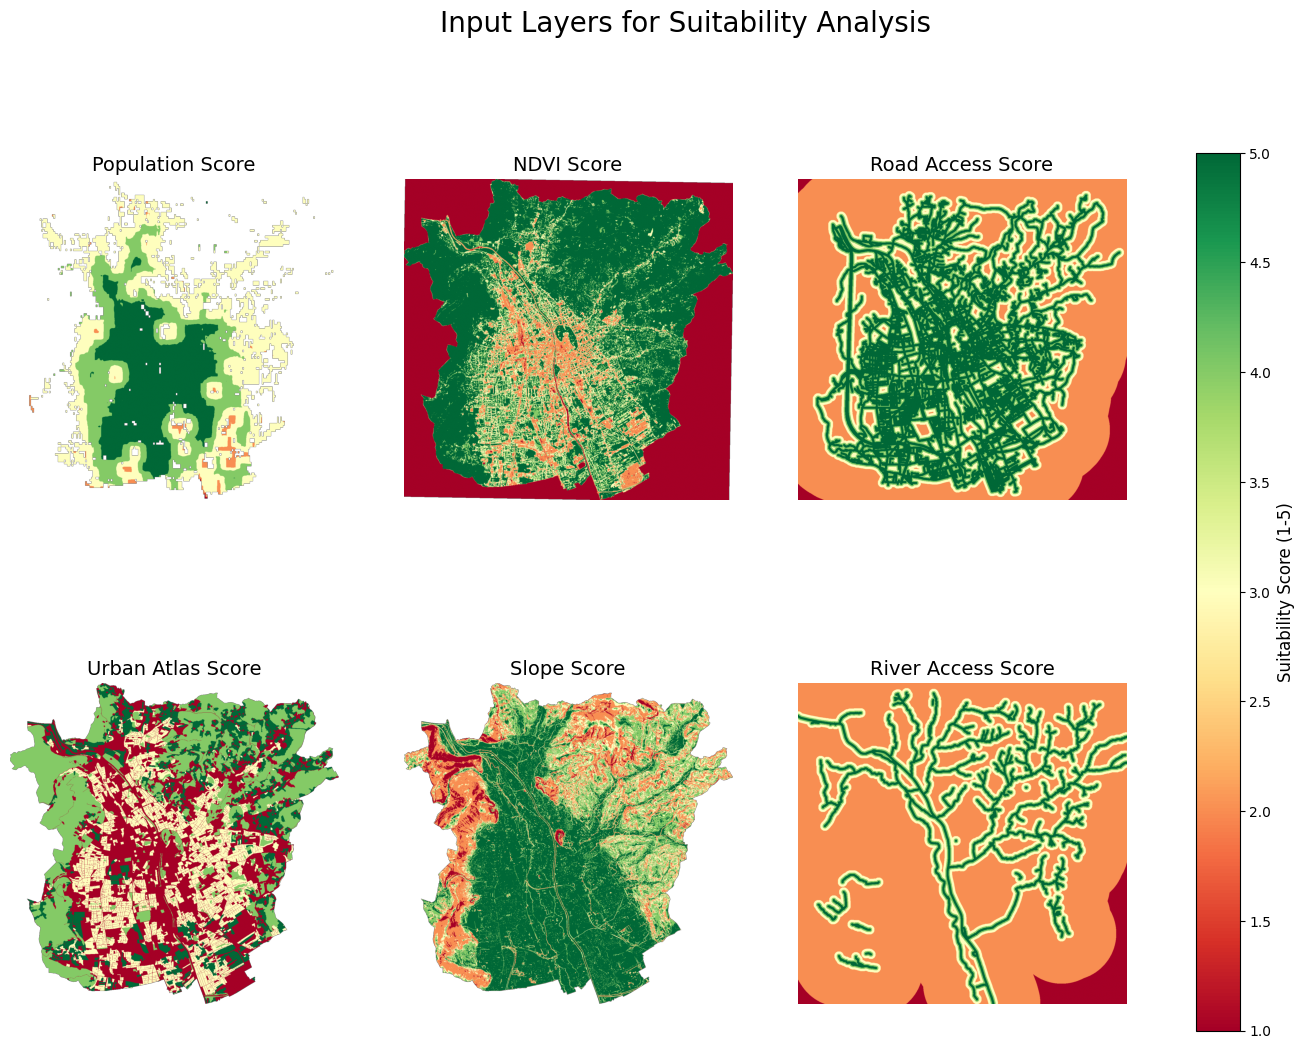

In [73]:
graz_gdf = gpd.read_file(data_dir / "Graz31256.geojson")

plot_files = [
    (out_pop_score, "Population Score"),
    (out_ndvi_score, "NDVI Score"),
    (out_road_score, "Road Access Score"),
    (out_ua_score, "Urban Atlas Score"),
    (out_slope_score, "Slope Score"),
    (out_river_score, "River Access Score")
]

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, (filepath, title) in enumerate(plot_files):
    ax = axes[idx]
    
    if filepath.exists():
        with rasterio.open(filepath) as src:
            data = src.read(1)
            data_masked = np.ma.masked_where(data == 0, data)
            im = ax.imshow(data_masked, cmap='RdYlGn', vmin=1, vmax=5)
            ax.set_title(title, fontsize=14)
            ax.axis('off')
    else:
        ax.text(0.5, 0.5, "File not found", ha='center')

cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.95)
cbar.set_label('Suitability Score (1-5)', fontsize=12)
plt.suptitle("Input Layers for Suitability Analysis", fontsize=20)
plt.savefig(data_dir / "suitability_input_layers.png", dpi=600)
plt.show()

# Creating suitability map graz

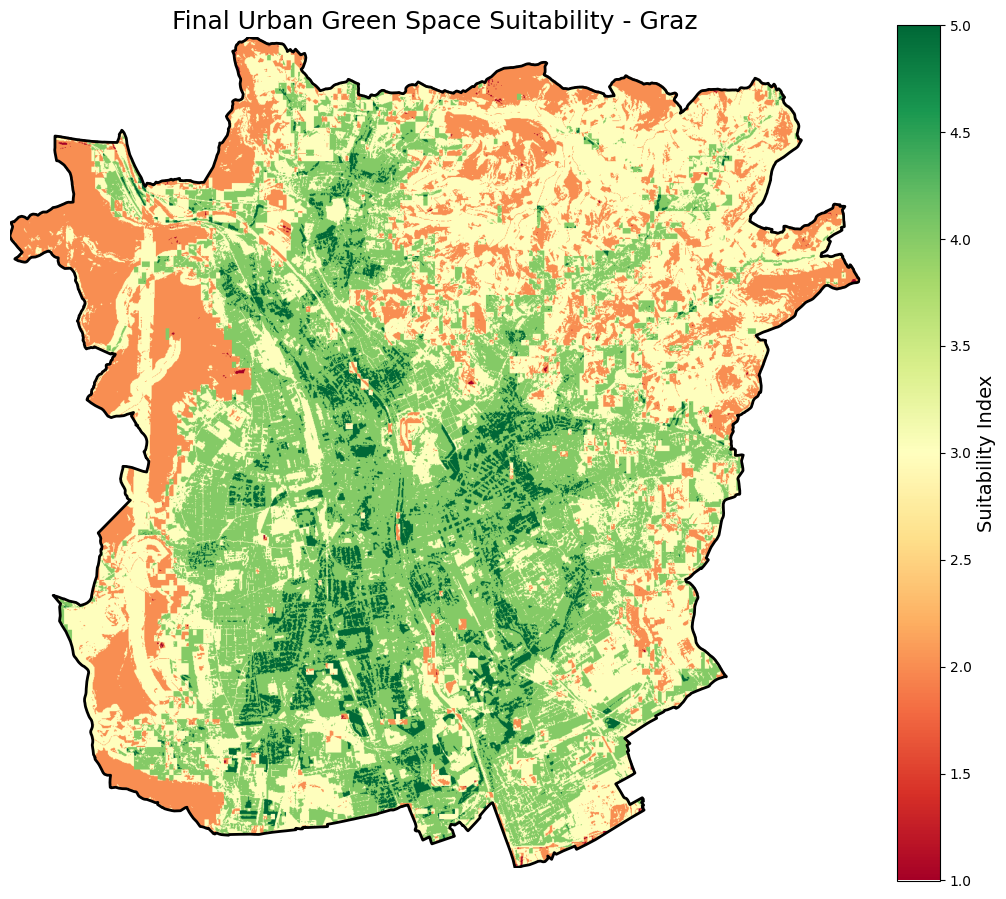

In [74]:

map_to_plot = out_classified # or out_final

plt.figure(figsize=(12, 12))

with rasterio.open(map_to_plot) as src:
    data = src.read(1)
    # Mask NoData (-9999)
    data_masked = np.ma.masked_where(data == src.nodata, data)
    
    from rasterio.plot import show
    ax = plt.gca()
    img = show(data_masked, transform=src.transform, ax=ax, cmap='RdYlGn', vmin=1, vmax=5)
    graz_gdf.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=2)
    plt.title("Final Urban Green Space Suitability - Graz", fontsize=18)
    plt.axis('off')
    cbar = plt.colorbar(ax.images[0], fraction=0.046, pad=0.04)
    cbar.set_label('Suitability Index', fontsize=14)
plt.savefig(data_dir / "final_suitability_map_graz.png", dpi=600)
plt.show()
